In this notebook we will practice how to load and preprocess data using tensorflow's data API. 

Also, see the following official [guide](https://www.tensorflow.org/guide/data#basic_mechanics)

## Excercise 1

This is excercise 13.9 in [this](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) book: 

### Problem statement:

Load the Fashion MNIST dataset; split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label. Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

In [1]:
import tensorflow as tf
from tensorflow import keras
print('tensorflow version:{}'.format(tf.__version__))
print('keras version: {}'.format(keras.__version__))

import numpy as np

tensorflow version:2.1.0
keras version: 2.2.4-tf


In [2]:
# import fashion-MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist 
# the above is the fashion_mnist module
# call fashion_mnist.load_data() to download the data using the above module
# fashion_mnist.load_data returns one tuple of training images and their labels, and another tuple of test images and their labels
# by default the images are saved at '~/.keras/datasets/fashion-mnist'
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
print('number of images in training set: {}'.format(len(X_train_full)))
print('number of images in test set: {}'.format(len(X_test)))

number of images in training set: 60000
number of images in test set: 10000


In [4]:
# the images are stored as numpy arrays
print('X_train_full is of type: {}'.format(type(X_train_full)))
print('y_train_full is of type: {}'.format(type(y_train_full)))

X_train_full is of type: <class 'numpy.ndarray'>
y_train_full is of type: <class 'numpy.ndarray'>


In [5]:
print('shape of X_train_full:{}'.format(X_train_full.shape))
print('minimum pixel value: {}'.format(X_train_full.min()))
print('maximum pixel value: {}'.format(X_train_full.max()))

shape of X_train_full:(60000, 28, 28)
minimum pixel value: 0
maximum pixel value: 255


In [6]:
# split X_train_full into a training set and a validation set
num_val = 10000 # number of instances in validation set
X_val, X_train = X_train_full[:num_val], X_train_full[num_val:]
y_val, y_train = y_train_full[:num_val], y_train_full[num_val:]

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", 
               "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [8]:
import matplotlib.pyplot as plt

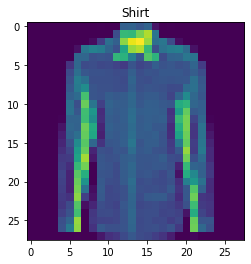

In [9]:
idx = 90
plt.figure()
plt.imshow(X_train[idx]/255.0)
plt.title(class_names[y_train[idx]])
plt.show()

In [10]:
# create tensorflow datasets from training, validation and test images
train_imgs = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_imgs = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_imgs = tf.data.Dataset.from_tensor_slices((X_test, y_test))
print('specs of train_imgs: {}'.format(train_imgs.element_spec))
print('specs of val_imgs: {}'.format(val_imgs.element_spec))
print('specs of test_imgs: {}'.format(test_imgs.element_spec))

specs of train_imgs: (TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))
specs of val_imgs: (TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))
specs of test_imgs: (TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))


In [11]:
# function to convert an individual record from the dataset into a serialized Example protobuf
# though we have not done it in this implementation, one should also store the shape of the tensor being serialized in an int64_list
# this is because while parsing the tensor from the protobuf, using parse_tensor, the shape 
# is not automatically inferred and needs to be set using 
# tf.ensure_shape, as has been done in tensor_from_Example_protobuf in the next code cell 
def tensor_to_Example_protobuf(record):
    '''Convert a record to a serialized Example protobuf. The record is assumed to be a tuple with the first entry being a tensor and the second entry being its label
    '''
    
    # convert the first entry of the record i.e. the image, to a Feature class
    # tensors should be converted to binary strings first
    bin_string = tf.io.serialize_tensor(record[0]).numpy()
    # since it is a string we can only store it as a BytesList but NOT as a FloatList or Int64List
    bytes_list = tf.train.BytesList(value = [bin_string]) # note that the value in BytesList has to be a list
    # convert the above BytesList to a Feature
    img = tf.train.Feature(bytes_list = bytes_list)
    
    # convert the second entry in the record i.e. the image-label to a Feature class
    # note that label are integers, so can be stored as Int64List
    int64_list = tf.train.Int64List(value = [record[1].numpy()])
    lbl = tf.train.Feature(int64_list = int64_list)
    
    # now add img and lbl, as obtained above, to a dictionary 
    # then use it to create an instance of the Features class
    feature = {'img': img, 'lbl': lbl}
    features = tf.train.Features(feature = feature)
    
    # use the features object above, to create an Example
    example = tf.train.Example(features = features)
    
    return example
    

In [12]:
# function to parse an Example protobuf or a serialized string obtained from it
# if batch == True, then the input is assumed to be a batch rather than a single example 
def tensor_from_Example_protobuf(example, batch = False):
    ''' function to parse a example protobuf generated from examples in fashion-MNIST dataset. The input can be an Example protobuf or a serialized string obtained from an Example protobuf The input to this function must be a serialized string '''
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'lbl': tf.io.FixedLenFeature([], tf.int64, default_value = 0)
        }
    
    if batch:
        parsed_examples = tf.io.parse_example(example, feature_description)
        # parsed_examples['img'] is itelf a tensor whose entries are serialized strings corresponding to the images in the batch
        # we therefore need to parse these strings back to tensors using tf.io.parse_tensor
        # This can be applied to the elements of parsed_examples['imgs'] using tf.map_fn
        imgs = tf.map_fn(lambda string: tf.io.parse_tensor(string, out_type = tf.uint8), 
                         parsed_examples['img'], 
                         dtype = tf.uint8) # since the type of output of the tf.map_fn is different from it's input type, we necessarily have to specify the dtype of the output
        # Note that "the parse_tensor function can't statically determine the shape of the parsed tensor"
        # this shape is needed as at the time of training the network otherwise it throws an error
        # Since we already know the shape, i.e. (None, 28, 28) where None is for the batch-dim, we can
        # explicitly specify this using tf.ensure_shape
        # see the following link for a discussion of this issue and the answer by aaudiber
        # https://github.com/tensorflow/tensorflow/issues/34989#issuecomment-566244812
        imgs = tf.ensure_shape(imgs, (None, 28, 28))
        lbls = tf.dtypes.cast(parsed_examples['lbl'], tf.uint8)
        return imgs, lbls
    
    # the input is a serialized string created from an Example protobuf
    if type(example)== bytes: 
        parsed_example = tf.io.parse_single_example(example, feature_description)
        img = tf.io.parse_tensor(parsed_example['img'].numpy(), out_type = tf.uint8)
        lbl = tf.dtypes.cast(parsed_example['lbl'],  tf.uint8)
    
    # the input is an Example protobuf instance WITHOUT being converted into a serialized string
    elif str(type(example)) == "<class 'tensorflow.core.example.example_pb2.Example'>":
        img = tf.io.parse_tensor(example.features.feature['img'].bytes_list.value[0], 
                                 out_type = tf.uint8)
        lbl = tf.convert_to_tensor(example.features.feature['lbl'].int64_list.value[0],
                                   dtype = tf.uint8)
    else:
        print('Error: The input is neither a serialized string nor an Example protobuf')
        return
    
    return img, lbl

### Test tensor_to_Example_protobuf and tensor_from_Example_protobuf

In [13]:
# extract a sample record from train_imgs for testing purposes
for item in train_imgs.take(1):
    train_item = item

In [14]:
# convert the record to Example 
ex = tensor_to_Example_protobuf(train_item)

# re-obtain the record from the Example protobuf and check its validity
print('Parsing Example protobuf')
img, lbl = tensor_from_Example_protobuf(ex)

# check the validity of img, lbl
print('image data was converted to Example and converted back faithfully: {}'.format(tf.math.reduce_all(img == train_item[0])))
print('label data was converted to Example and converted back faithfully: {}'.format(tf.math.reduce_all(lbl == train_item[1])))

print('Parsing serialized string')
img, lbl = tensor_from_Example_protobuf(ex.SerializeToString())

# check the validity of img, lbl
print('image data was converted to Example and converted back faithfully: {}'.format(tf.math.reduce_all(img == train_item[0])))
print('label data was converted to Example and converted back faithfully: {}'.format(tf.math.reduce_all(lbl == train_item[1])))


Parsing Example protobuf
image data was converted to Example and converted back faithfully: True
label data was converted to Example and converted back faithfully: True
Parsing serialized string
image data was converted to Example and converted back faithfully: True
label data was converted to Example and converted back faithfully: True


### Suggested Improvements for storing images in TFRecord files

Note that as explained in [this](https://medium.com/@prasad.pai/how-to-use-tfrecord-with-datasets-and-iterators-in-tensorflow-with-code-samples-ffee57d298af) post, converting the tensor/numpy-array representation of an image to an Example protobuf incurs a huge space in the memory leading to the resulting TFRecord files being much more bulky than the original image data. The reason essentially boils down to the fact that each element of the array is converted to it's own binary string. On the otherhand, this spatial overhead can be overcome by directly storing the image in its jpeg or png format by using [tf.io.encode_jpeg](https://www.tensorflow.org/api_docs/python/tf/io/encode_jpeg) (this is also aliased as tf.image.encode_jpeg) or  [tf.image.encode_png](https://www.tensorflow.org/api_docs/python/tf/image/encode_png) (this does NOT have an tf.io.encode_jpeg alias) respectively.  

#### jpeg vs png

In [15]:
im_lb = next(iter(train_imgs))
im_lb[0].shape

TensorShape([28, 28])

In [16]:
im_jpeg = tf.io.encode_jpeg(tf.expand_dims(im_lb[0], 2))
im_png = tf.image.encode_png(tf.expand_dims(im_lb[0], 2))
im_decode_jpeg = tf.io.decode_jpeg(im_jpeg)
im_decode_png = tf.io.decode_jpeg(im_png)

Note that while png format stores the image as is but jpeg format applies image compression which changes some of the pixel values in the image. Thus the image restored from png matches the original image tensor exactly, however, the image restored from jpeg does not match the original image tensor in all pixel values. 

In [17]:
match_png = tf.math.reduce_all(tf.squeeze(im_decode_png, 2) == im_lb[0])
print('restored png image matches the original image tensor: {}'.format(match_png))
match_jpeg = tf.math.reduce_all(tf.squeeze(im_decode_jpeg, 2) == im_lb[0])
print('restored jpeg image matches the original image tensor: {}'.format(match_jpeg))

restored png image matches the original image tensor: True
restored jpeg image matches the original image tensor: False


However, visually there is almost no difference betweent the original image, the jpeg image or the png image

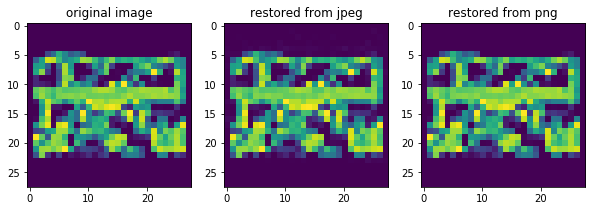

In [18]:
fig, ax = plt.subplots(figsize = (10, 5), nrows = 1, ncols = 3)
ax[0].imshow(im_lb[0])
ax[0].set_title('original image')
ax[1].imshow(tf.squeeze(im_decode_jpeg, axis = 2))
ax[1].set_title('restored from jpeg')
ax[2].imshow(tf.squeeze(im_decode_png, axis = 2))
ax[2].set_title('restored from png')
plt.show()

#### functions to convert png, jpeg to and from Example protobuf

In [1]:
# function to convert a png/jpeg image to Example protobuf
def image_to_Example_protobuf(record, format_ = 'png'):
    if format_ == 'png':
        bin_string = tf.image.encode_png(tf.expand_dims(record[0], 2)).numpy()
    elif format_ == 'jpeg':
        bin_string = tf.image.encode_jpeg(tf.expand_dims(record[0], 2)).numpy()
    else:
        print('Error: The provided format is neither png not jpeg')
        return  
    
    format_list = tf.train.BytesList(value = [format_.encode('utf-8')]) # encode python strings to bytes using 
                                                                        # string.encode('utf-8')
                                                                        # https://stackoverflow.com/questions/7585435/best-way-to-convert-string-to-bytes-in-python-3
    form = tf.train.Feature(bytes_list = format_list)
    
    
    bytes_list = tf.train.BytesList(value = [bin_string])
    img = tf.train.Feature(bytes_list = bytes_list)
    
    n_rows, n_cols = record[0].shape[0], record[0].shape[1]
    rows_list = tf.train.Int64List(value = [n_rows])
    cols_list = tf.train.Int64List(value = [n_cols])
    rows = tf.train.Feature(int64_list = rows_list)
    cols = tf.train.Feature(int64_list = cols_list)
    
    lbl_list = tf.train.Int64List(value = [record[1].numpy()])
    lbl = tf.train.Feature(int64_list = lbl_list)
    
    feature_dict = {'img': img, 'format': form ,'rows': rows, 'cols': cols, 'lbl': lbl}
    features = tf.train.Features(feature = feature_dict)
    
    example = tf.train.Example(features = features)
    
    return example
    

In [2]:
# function to parse an Example protobuf created from a png/jpeg format
def image_from_Example_protobuf(example, batch = False):
    
    features_description = {
        'img': tf.io.FixedLenFeature([], tf.string, default_value = ''),
        'format': tf.io.FixedLenFeature([], tf.string, default_value = 'png'),
        'rows': tf.io.FixedLenFeature([], tf.int64, default_value = 0),
        'cols':tf.io.FixedLenFeature([], tf.int64, default_value = 0),
        'lbl':tf.io.FixedLenFeature([], tf.int64, default_value = 0)
    }
    
    if batch:
        parsed_examples = tf.io.parse_example(example, features_description) 
        imgs = tf.map_fn(lambda x: tf.io.decode_image(x), 
                         parsed_examples['img'],
                         dtype = tf.uint8) # recall that since the type of output of tf.map_fn 
                                           # is different from it's input type, 
                                           # we necessarily have to specify the 
                                           # dtype of the output
        lbls = tf.dtypes.cast(parsed_examples['lbl'], tf.uint8)
        
        # In prinicple it should be possible pass the saved info on rows and cols to tf.ensure_shape()
        # I was not able to figure out how to do this, so hard-coding the shape here
        imgs = tf.ensure_shape(imgs, (None, 28, 28, 1))
         
        return imgs, lbls
    
    # if example is a serialized string obtained from an Example protobuf
    if type(example) == bytes:
        record = tf.io.parse_single_example(example, features_description)
        img = tf.io.decode_image(record['img']) 
        lbl = tf.dtypes.cast(record['lbl'], tf.uint8)
    
    # if example is an Example protobuf WITHOUT being serialized to a string
    elif str(type(example)) == "<class 'tensorflow.core.example.example_pb2.Example'>": 
        img_string = example.features.feature['img'].bytes_list.value[0]
        img = tf.io.decode_image(img_string)
        lbl = tf.convert_to_tensor(example.features.feature['lbl'].int64_list.value[0], 
                                   dtype = tf.uint8)
    
    # note that in both cases above, the image will have shape: (height, columns, channel)
    # with channel = 1 for grayscale images such as in fashion-mnist
    
    return img, lbl

In [51]:
ex = image_to_Example_protobuf(im_lb)
ex_str = ex.SerializeToString()

In [54]:
ex_rec = image_from_Example_protobuf(ex)
tf.math.reduce_all(tf.squeeze(ex_rec[0],2) == im_lb[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### Store data in TFRecord files

#### Training set

There are 50000 images in the training set. Let us divide them into 50 TFRecord files with each file containing serialized example protobufs for 1000 images.

In [23]:
# shuffle the training set
seed = 42
buffer_size = 20000
train_shuffled = train_imgs.shuffle(buffer_size = buffer_size, seed = seed)
train_itr = iter(train_shuffled)

In [24]:
train_filepaths = []
compression = tf.io.TFRecordOptions(compression_type = 'GZIP')

for file_num in range(50):
    filename = 'fashion_MNIST_TFRecord/train_tfrecord_'+ str(file_num)+'.tfrecord'
    train_filepaths.append(filename)
    print('\nfile_num: {}'.format(file_num))
    with tf.io.TFRecordWriter(filename, compression) as f:
        for item_num in range(1000):
            train_item = next(train_itr)
            serialized_example = image_to_Example_protobuf(train_item)
            f.write(serialized_example.SerializeToString())
            if item_num%10 ==0:
                print('*', end = '')


file_num: 0
****************************************************************************************************
file_num: 1
****************************************************************************************************
file_num: 2
****************************************************************************************************
file_num: 3
****************************************************************************************************
file_num: 4
****************************************************************************************************
file_num: 5
****************************************************************************************************
file_num: 6
****************************************************************************************************
file_num: 7
****************************************************************************************************
file_num: 8
***********************************************************************************

#### Validation set

There are 10000 images in the validation set. We will store these in 10 TFRecord files, each containing serialized example protobufs for 1000 images. 

In [25]:
val_filepaths = []
val_itr = iter(val_imgs)

for file_num in range(10):
    filename = 'fashion_MNIST_TFRecord/val_tfrecord_'+ str(file_num) + '.tfrecord'
    val_filepaths.append(filename)
    print('\nfile_num: {}'.format(file_num))
    with tf.io.TFRecordWriter(filename, compression) as f:
        for item_num in range(1000):
            val_item = next(val_itr)
            serialized_example = image_to_Example_protobuf(val_item)
            f.write(serialized_example.SerializeToString())
            if item_num%10 == 0:
                print('*', end = '')


file_num: 0
****************************************************************************************************
file_num: 1
****************************************************************************************************
file_num: 2
****************************************************************************************************
file_num: 3
****************************************************************************************************
file_num: 4
****************************************************************************************************
file_num: 5
****************************************************************************************************
file_num: 6
****************************************************************************************************
file_num: 7
****************************************************************************************************
file_num: 8
***********************************************************************************

#### Test set

The test set contains 10000 test images. We will create 10 TFRecord files for these, each storing the serialized example protobuf for 1000 images. 

In [26]:
test_filepaths = []
test_itr = iter(test_imgs)

for file_num in range(10):
    filename = 'fashion_MNIST_TFRecord/test_tfrecord_' + str(file_num) + '.tfrecord'
    test_filepaths.append(filename)
    print('\nfile_num: {}'.format(file_num))
    with tf.io.TFRecordWriter(filename, compression) as f:
        for item_num in range(1000):
            test_item = next(test_itr)
            serialized_example = image_to_Example_protobuf(test_item)
            f.write(serialized_example.SerializeToString())
            if item_num%10==0:
                print('*', end = '')


file_num: 0
****************************************************************************************************
file_num: 1
****************************************************************************************************
file_num: 2
****************************************************************************************************
file_num: 3
****************************************************************************************************
file_num: 4
****************************************************************************************************
file_num: 5
****************************************************************************************************
file_num: 6
****************************************************************************************************
file_num: 7
****************************************************************************************************
file_num: 8
***********************************************************************************

### Create a dataset from the saved TFRecord files 

In [3]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# function to parse img_data from Example protobuf and normalize its max to 1
def parse_and_normalize(img_batch):
    parsed_batch = image_from_Example_protobuf(img_batch, batch = True)
    
    # normalize the images and add a channel dim. to the end 
    # Conv2d layers in keras need input_shape to include a channel dim (even for grayscale images)
    
    imgs = tf.cast(parsed_batch[0], tf.float32)/255.0
    
    return imgs , parsed_batch[1]

In [5]:
# function to return a dataset created from specified TFRecord files

def create_dataset(filepaths, batch_size, num_parallel_reads, compression_type = 'GZIP', prefetch = 1):
    # generically, tf.data.TFRecordDataset accepts a list of filepaths
    # in order to specify files using glob patterns rather than a list of filepaths, we do the following
    # use tf.data.TFRecordDataset.list_files() to create a filepath_dataset corresponding to a file pattern
    # then pass this filepath_dataset to tf.data.TFRecordDataset
    filepaths_dataset = tf.data.TFRecordDataset.list_files(filepaths)
    dataset = tf.data.TFRecordDataset(filepaths_dataset, 
                                      compression_type = compression_type,
                                      num_parallel_reads = num_parallel_reads).batch(batch_size)
    parsed_dataset = dataset.map(parse_and_normalize).prefetch(prefetch)
    
    return parsed_dataset

In [6]:
# training dataset
train_batch_size = 5000
train_num_parallel_reads = 5
train_filepaths = 'fashion_MNIST_TFRecord/train_tfrecord_*.tfrecord'
train_data = create_dataset(filepaths = train_filepaths, 
                            batch_size = train_batch_size, 
                            num_parallel_reads = train_num_parallel_reads)

In [7]:
# validation dataset
valid_batch_size = 5000
valid_filepaths = "fashion_MNIST_TFRecord/val_tfrecord_*.tfrecord"
valid_num_parallel_reads = 5
valid_data = create_dataset(filepaths = valid_filepaths, 
                            batch_size = valid_batch_size, 
                            num_parallel_reads = valid_num_parallel_reads)

### Save run logs for TensorBoard

In [8]:
import os
import time

In [9]:
log_dir = os.path.join(os.getcwd(), 'log_dir')
print(log_dir)

/home/prarit/MachineLearningProjects/TensorFlowDataAPI/log_dir


In [10]:
# https://www.programiz.com/python-programming/datetime/strftime
run_id = time.strftime('run_%Y_%m_%d_%H_%M_%S')
run_filename = os.path.join(log_dir, run_id)
print(run_filename)

/home/prarit/MachineLearningProjects/TensorFlowDataAPI/log_dir/run_2020_03_03_18_50_29


### Define a CNN model 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

In [12]:
# function to define a sequential model with specified kernels for sequential layers
# we assume the stride and dilation to be 1 in each layer for this model
# we will also use 'same' padding in all layers to keep the size of the output same as that of the input in each Conv. layer
# see the following discussion for difference between 'same' and 'valid' padding
# https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
def build_model(kernel_list, input_shape):
    '''
    kernel_list: list of tuples of num_units, kernel sizes for the Conv. layers
    input_shape: input shape of images, note that by default keras expects input_shape to have channels last
    
    '''
    model = Sequential()
    units, kernel_size = kernel_list[0]
    conv2d = Conv2D(filters = units, kernel_size = kernel_size, 
                    input_shape = input_shape, padding = 'same', activation = 'relu')
    model.add(conv2d)
    
    for units, kernel_size in kernel_list[1:]:
        conv2d = Conv2D(filters = units, kernel_size = kernel_size, 
                        padding = 'same', activation = 'relu')
        model.add(conv2d)
    
    model.add(Flatten())
    
    # classifier layer
    hidden1 = Dense(units = 256, activation = 'relu')
    model.add(hidden1)
    
    output = Dense(units = 10, activation = 'softmax')
    model.add(output)
    
    return model

In [13]:
K.clear_session()
kernel_list = [(10, 3), (10, 5), (10, 7)]
input_shape = (28,28,1)
model = build_model(kernel_list, input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 10)        2510      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 10)        4910      
_________________________________________________________________
flatten (Flatten)            (None, 7840)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2007296   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 2,017,386
Trainable params: 2,017,386
Non-trainable params: 0
______________________________________________

In [14]:
# compile the model
loss = 'sparse_categorical_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [15]:
# callback for TensorBoard
# check the following tutorial
# https://www.tensorflow.org/tensorboard/get_started
tensorboard_callback = keras.callbacks.TensorBoard(run_filename)

In [16]:
# I first ran this for 50 epochs and found that the training and validation losses start to diverge after about 10 epochs
epochs = 15
history = model.fit(train_data, epochs = epochs, 
                    validation_data = valid_data,
                    callbacks = [tensorboard_callback])

Epoch 1/15
10/10 [==============================] - 4s 439ms/step - loss: 1.3283 - accuracy: 0.5600 - val_loss: 0.8151 - val_accuracy: 0.7079
Epoch 2/15
10/10 [==============================] - 4s 391ms/step - loss: 0.7312 - accuracy: 0.7451 - val_loss: 0.6261 - val_accuracy: 0.7777
Epoch 3/15
10/10 [==============================] - 4s 410ms/step - loss: 0.5776 - accuracy: 0.7902 - val_loss: 0.5201 - val_accuracy: 0.8174
Epoch 4/15
10/10 [==============================] - 4s 397ms/step - loss: 0.4952 - accuracy: 0.8257 - val_loss: 0.4597 - val_accuracy: 0.8432
Epoch 5/15
10/10 [==============================] - 4s 421ms/step - loss: 0.4435 - accuracy: 0.8448 - val_loss: 0.4215 - val_accuracy: 0.8536
Epoch 6/15
10/10 [==============================] - 4s 402ms/step - loss: 0.4082 - accuracy: 0.8560 - val_loss: 0.3982 - val_accuracy: 0.8586
Epoch 7/15
10/10 [==============================] - 4s 409ms/step - loss: 0.3839 - accuracy: 0.8645 - val_loss: 0.3804 - val_accuracy: 0.8642
Epoch 

In [17]:
# model's predictions on the test set
test_batch_size = 10000
test_num_parallel_reads = 10
test_filepaths = "fashion_MNIST_TFRecord/test_tfrecord_*.tfrecord"
test_data = create_dataset(filepaths = test_filepaths, 
                            batch_size = test_batch_size, 
                            num_parallel_reads = test_num_parallel_reads)

test_imgs, test_labels = next(iter(test_data))

In [18]:
predictions = tf.math.argmax(model.predict(test_imgs), axis = 1 )

In [19]:
test_labels

<tf.Tensor: shape=(10000,), dtype=uint8, numpy=array([6, 7, 8, ..., 7, 9, 1], dtype=uint8)>

In [20]:
check_predictions = tf.equal(tf.cast(predictions, dtype = tf.uint8), test_labels)
check_predictions

<tf.Tensor: shape=(10000,), dtype=bool, numpy=array([ True,  True,  True, ...,  True,  True,  True])>

In [21]:
accuracy = tf.math.reduce_sum(tf.cast(check_predictions, dtype = tf.float32))/check_predictions.shape[0]
print(accuracy.numpy())

0.881


In [22]:
# Alternatively, we could have just used the model's evaluate method
test_loss, test_accuracy = model.evaluate(test_data)

      1/Unknown - 1s 1s/step - loss: 0.3304 - accuracy: 0.8810

In [23]:
import pandas as pd

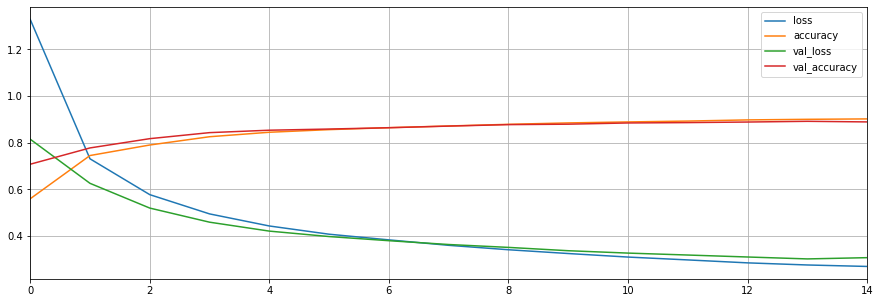

In [24]:
# plots of accuracy and loss as function of time
pd.DataFrame(history.history).plot(figsize = (15, 5))
plt.grid(True)
plt.show()

### Profiling traces in Tensorboard

I was not able to get the profiling traces to work due insufficient privileges. 

I included the CUPTI directory in the LD_LIBRARY_PATH by including the following line to /~.bashrc

export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI-10.1/lib64

The way to reset the user priviliges is suggested in the answers by rameshgunjal and Sanjiv.Satoor in [this](https://devtalk.nvidia.com/default/topic/1049421/visual-profiler-and-nvprof/nvprof-warning-the-user-does-not-have-permission-to-profile-on-the-target-device-/) thread. I tried doing that but didn't work. :( i.e. even after following what they say and restarting my server, I still get 

RmProfilingAdminOnly: 1

upon running

$ cat /proc/driver/nvidia/params | grep RmProfilingAdminOnly

I don't know how to fix this. :(


As is also mentioned in [this](https://github.com/tensorflow/tensorboard/issues/2911) discussion, there seems to be a bug in tensorboard due to which at times the training metrics and losses do not show up in the scalar plots. If this happens, then kill and restart tensorboard. 

In [27]:
%load_ext tensorboard
# https://github.com/tensorflow/tensorboard/issues/2689
# https://stackoverflow.com/questions/59308924/how-to-profile-a-keras-predict-call-with-tensorboard
# https://www.tensorflow.org/tensorboard/tensorboard_profiling_keras
# https://devtalk.nvidia.com/default/topic/995815/cuda-setup-and-installation/path-amp-ld_library_path/
# https://github.com/tensorflow/tensorflow/issues/35860
# https://devtalk.nvidia.com/default/topic/1049421/visual-profiler-and-nvprof/nvprof-warning-the-user-does-not-have-permission-to-profile-on-the-target-device-/
# make sure to not have any space aroung the = sign in the following
# make sure to tunnel the intended port for tensorboard from 
# the remote server to the local server before running the following command
%tensorboard --logdir=log_dir --port=7007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
